### Import modules and read data:

In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxc
import numpy as np
import pandas as pd

In [2]:
# G = nx.read_gml('./Graphs/all_data_corr.gml')
G = nx.read_gml('./Graphs/null_model.gml')
nx.info(G)

'Graph with 929 nodes and 5587 edges'

In [3]:
states_adj = {}

with open('./Data/usa-state-data.json', 'r') as state_json:
    states_adj = json.load(state_json)

In [4]:
REGION_MAP = {'Northeast': 1, 'South': 2, 'Midwest': 3, 'West': 4}
ad_path = './Figs/actual_data_'
nm_path = './Figs/null_model_'

### Network vis

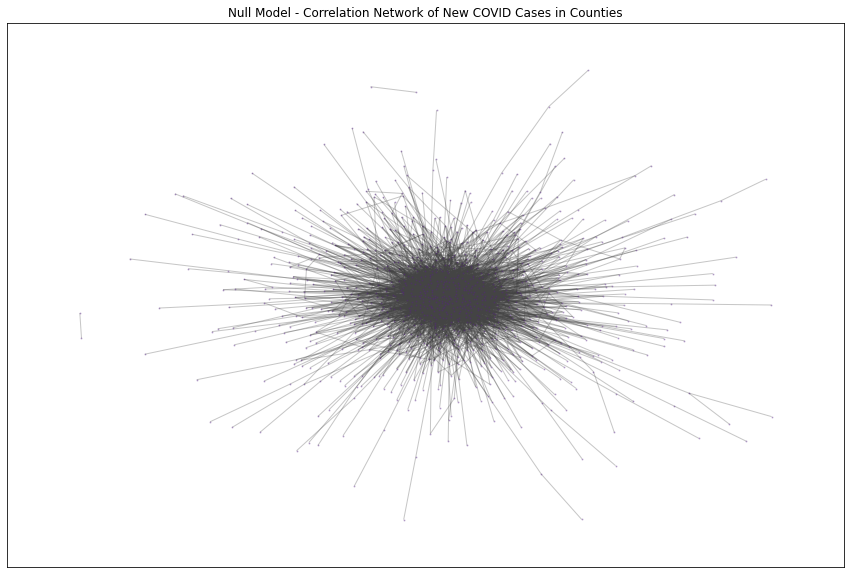

In [5]:
pos = nx.spring_layout(G, k = 0.1, weight = 'weight')

fig = plt.figure(figsize = (15, 10))
nx.draw_networkx(G, pos = pos, node_size = 1, node_color = '#552583', edge_color = '#444444', alpha = 0.3, with_labels = False)
# plt.title('Correlation Network of New COVID Cases in Counties')
plt.title('Null Model - Correlation Network of New COVID Cases in Counties')
plt.savefig(nm_path + 'corr_nw_raw')
plt.show()
plt.close()

### Community Detection 

In [6]:
def add_node_community(G: nx.Graph, communities: list, label) -> None:
    """Add a marker for the community to the nodes
    Parameters:
        G (nx.Graph): a network
        communities (list): the list of communities
        label (str): the label for the community being added
    Returns:
        None"""
    
#     nx.set_node_attributes(G, values = 99, name = label)  # set default value for all nodes
    
    # set specific value for nodes we're interested in
    for i, com in enumerate(communities):
        for c in com:
            G.nodes[c][label] = i + 1

In [7]:
def add_edge_community(G: nx.Graph, label) -> None:
    """Add a marker for the community to the edges
    Parameters:
        G (nx.Graph): a network
        label (str): the label for the community
    Returns:
        None"""
    
    for x, y in G.edges:
#         if G.nodes[x][label] == G.nodes[y][label]:  # nodes are in the same community i.e. internal edge
        if label in G.nodes[x] and label in G.nodes[y] and G.nodes[x][label] == G.nodes[y][label]:  # nodes are in the same community i.e. internal edge
            G.edges[x, y][label] = G.nodes[x][label]
        else:  # external edge
            G.edges[x, y][label] = 0

In [8]:
def get_colour(i, r_off = 1, g_off = 1, b_off = 1) -> (float, float, float):
    """Get colour for a node
    Parameters:
        i (int): community label
        r_off (int): red offset
        g_off (int): green offset
        b_off (int): blue offset
    Returns:
        float: red value
        float: green value
        float: blue value"""
    
    n, low, high = 16, 0.1, 0.9
    span = high - low
    
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)  
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    
    return (r, g, b)

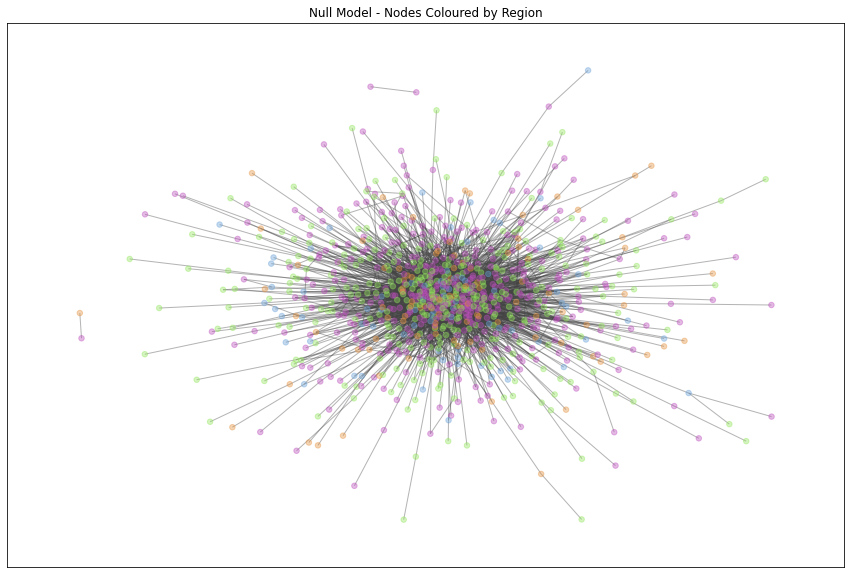

In [9]:
node_colour_region = [get_colour(REGION_MAP[G.nodes[i]['Region']]) for i in G.nodes]

fig = plt.figure(figsize = (15, 10))
nx.draw_networkx(G, pos = pos, node_size = 30, node_color = node_colour_region, edge_color = '#444444', alpha = 0.4, with_labels = False)
# plt.title('Nodes Coloured by Region')
plt.title('Null Model - Nodes Coloured by Region')
plt.savefig(nm_path + 'corr_nw_region')
plt.show()
plt.close()

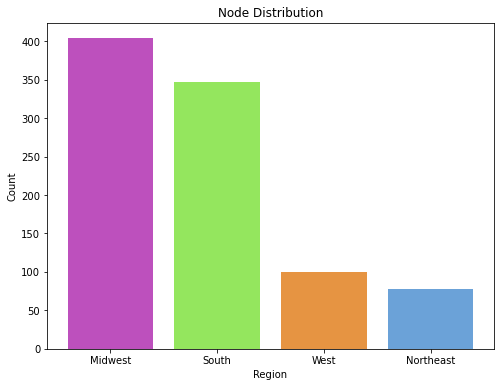

In [10]:
s = pd.Series([G.nodes[i]['Region'] for i in G.nodes]).value_counts()
s = pd.DataFrame(s).reset_index().rename(columns = {'index': 'region', 0: 'count'})

fig = plt.figure(figsize = (8, 6))
for i in range(len(s)):
    plt.bar(s.loc[i, 'region'], s.loc[i]['count'], color = get_colour(REGION_MAP[s.loc[i, 'region']]))
plt.title('Node Distribution')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()
plt.close()

In [11]:
def community_plotter(G: nx.Graph, label, title) -> None:
    """Plot a network with communities
    Parameters:
        G (nx.Graph): a network
        label (str): the label for the community
        title (str): the title for the plot
    Returns:
        None"""
    
    external_edges = [(i, j) for i, j in G.edges if G.edges[i, j][label] == 0]
    internal_edges = [(i, j) for i, j in G.edges if G.edges[i, j][label] > 0]
    
#     com_nodes = [i for i in G.nodes if G.nodes[i][label] != 99]
    com_nodes = [i for i in G.nodes if label in G.nodes[i]]
    
    internal_colour = ['#000000' for _ in internal_edges]
    node_colour = [get_colour(G.nodes[i][label]) for i in com_nodes]
    
    fig = plt.figure(figsize = (15, 10))
    nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = com_nodes, edgelist = external_edges, edge_color = '#000000', node_color = node_colour, style = 'dashed', alpha = 0.4, with_labels = False)
    nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = com_nodes, edgelist = internal_edges, edge_color = internal_colour, node_color = node_colour, alpha = 0.4, with_labels = False)
    plt.title(title)
    plt.savefig(nm_path + label)
    plt.show()
    plt.close()

In [12]:
def community_stats(communities: list) -> None:
    """Get community statistics
    Parameters:
        communities (list): a list of communities
    Returns:
        None"""
    
    lens = np.array([len(c) for c in communities])
    
    print('Max size:', np.max(lens))
    print('Mean size:', np.mean(lens))
    print('Std. Dev.:', np.std(lens))
    print('Median size:', np.median(lens))
    print('Min size:', np.min(lens))

#### 1. Greedy Modularity Maximisation

In [13]:
def greedy_modularity_max(G: nx.Graph, weight = 'weight', threshold = 4, label = 'gmm') -> list:
    """Apply greedy modularity maximisation to find communities
    Parameters:
        G (nx.Graph): a network
        weight (str): the edge attribute
        threshold (int): minimum community size (default: 4)
        label (str): the label for the community (default: gmm)
    Returns:
        list: a list of communities detected"""
    
    gmm_com = nxc.greedy_modularity_communities(G, weight)
    
    filtered_gmm_com = [c for c in gmm_com if len(c) > threshold]
    
    community_stats(filtered_gmm_com)
    
    print('Communities detected:', len(filtered_gmm_com))
    
    add_node_community(G, filtered_gmm_com, label)
    add_edge_community(G, label)
    
    community_plotter(G, label, 'Null Model - Community Detection using Greedy Modularity Maximisation')
    
    return filtered_gmm_com

Max size: 201
Mean size: 81.0
Std. Dev.: 76.06456587543363
Median size: 43.0
Min size: 5
Communities detected: 11


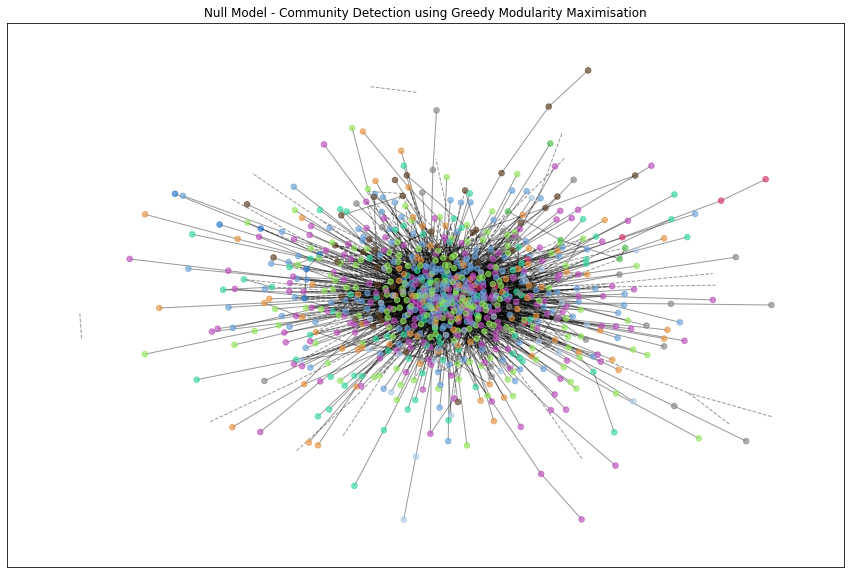

In [14]:
gmm_coms = greedy_modularity_max(G)

#### 2. k-Cliques

In [15]:
def k_clique(G: nx.Graph, k, label = 'kclique') -> list:
    """Find k-clique communities
    Parameters:
        G (nx.Graph): a network
        k (int): clique size
        label (str): the label for the community (default: kclique)
    Returns:
        list: a list of communities detected"""
    
    kc_com = list(nxc.k_clique_communities(G, 5))
    
    community_stats(kc_com)
    
    print('Communities detected:', len(kc_com))
    
    add_node_community(G, kc_com, label)
    add_edge_community(G, label)
    
    community_plotter(G, label, 'Null Model - Community Detection using {}-Cliques'.format(k))
    
    return kc_com

Max size: 165
Mean size: 21.1
Std. Dev.: 47.96759322709448
Median size: 5.0
Min size: 5
Communities detected: 10


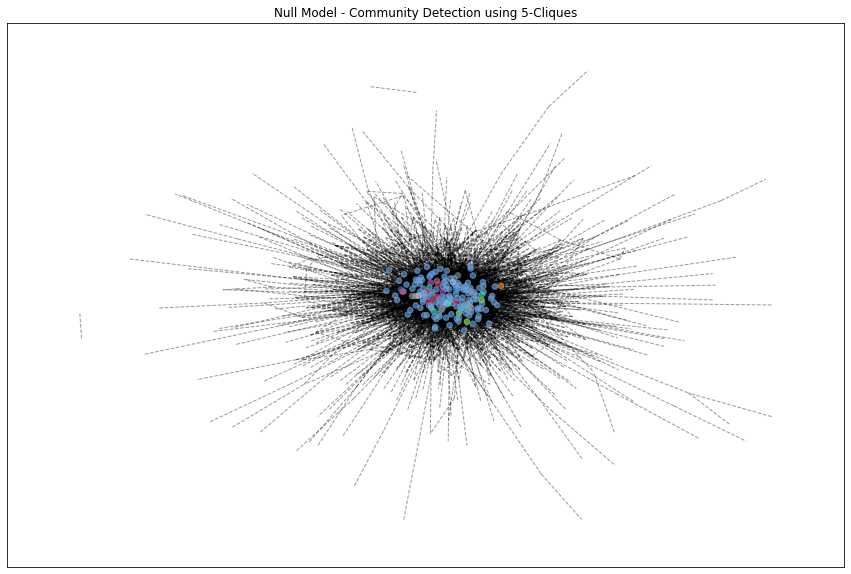

In [16]:
kc_coms = k_clique(G, 5)

### Community Analysis

In [18]:
def show_community(communities: list, target, label, algo) -> None:
    """Placeholder
    Parameters:
        communities (list): a list of communities detected
        target (str): the node we're looking for
        label (str): the label for the algorithm
        algo (str): the community detection algorithm used
    Returns:
        None"""
    
    nodes_list = None
    count = 0
    
    for com in communities:
        count += 1
        if target in com:
            nodes_list = [n for n in com]
            break
       
    if nodes_list:
        com_states = pd.DataFrame([n[-2 :] for n in nodes_list], columns = ['State'])
        com_states['Region'] = com_states['State'].apply(lambda x: states_adj[x]['region'])

        region_vc = pd.DataFrame(com_states['Region'].value_counts()).reset_index().rename(columns = {'index': 'Region', 'Region': 'Counts'})

#         print('Community:', nodes_list)
        print('Community size:', len(nodes_list))
        print('Regions:\n', region_vc)

        for i in range(len(region_vc)):
            plt.bar(region_vc.loc[i, 'Region'], region_vc.loc[i]['Counts'], color = get_colour(REGION_MAP[region_vc.loc[i, 'Region']]))
        plt.title('Null Model - Node Distribution in\nthe {} Community'.format(target))
        plt.xlabel('Region')
        plt.ylabel('Count')
        plt.savefig(nm_path + 'node_distro_{}_{}'.format(target, label))
        plt.show()
        plt.close()

        internal_edges = [(e[0], e[1]) for e in G.edges(data = True) if e[2][label] == count]
        external_edges = [(e[0], e[1]) for e in G.edges(data = True) if e[2][label] != count]
        
        node_colour = [get_colour(REGION_MAP[states_adj[i[-2 :]]['region']]) for i in nodes_list]
        
        fig = plt.figure(figsize = (15, 10))
#         nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = nodes_list, edgelist = internal_edges, edge_color = '#000000', node_color = '#552583', alpha = 0.5, with_labels = False)
        nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = nodes_list, edgelist = internal_edges, edge_color = '#000000', node_color = node_colour, alpha = 0.5, with_labels = False)
#         nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = nodes_list, edgelist = external_edges, edge_color = '#000000', node_color = '#552583', style = 'dashed', alpha = 0.1, with_labels = False)
        nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = nodes_list, edgelist = external_edges, edge_color = '#000000', node_color = node_colour, style = 'dashed', alpha = 0.1, with_labels = False)
        plt.title('Null Model - {} Community using {}'.format(target, algo))
        plt.savefig(nm_path + 'comm_{}_{}'.format(target, label))
        plt.show()
        plt.close()
        
    else:
        print('No community found')

Community size: 199
Regions:
       Region  Counts
0      South      85
1    Midwest      81
2       West      19
3  Northeast      14


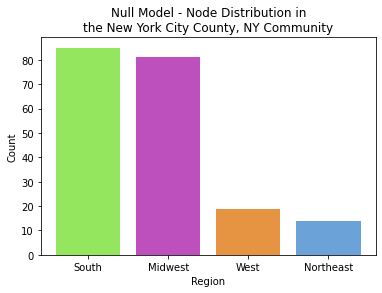

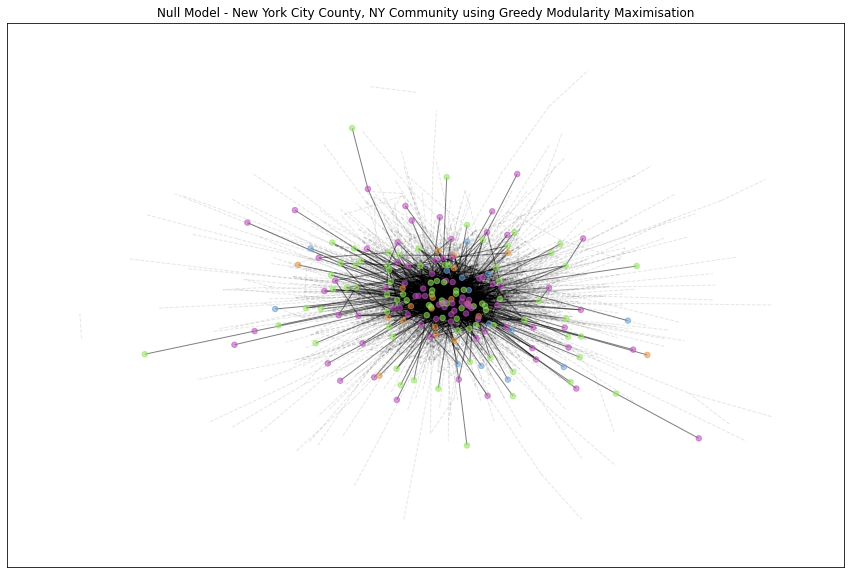

In [19]:
show_community(gmm_coms, 'New York City County, NY', 'gmm', 'Greedy Modularity Maximisation')

In [20]:
show_community(kc_coms, 'New York City County, NY', 'kclique', '5-Cliques')

No community found


Community size: 194
Regions:
       Region  Counts
0    Midwest      98
1      South      64
2       West      18
3  Northeast      14


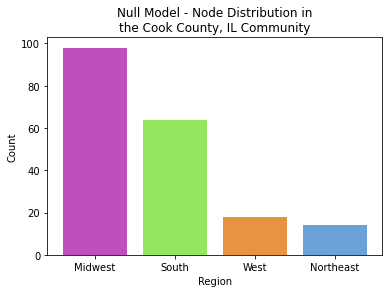

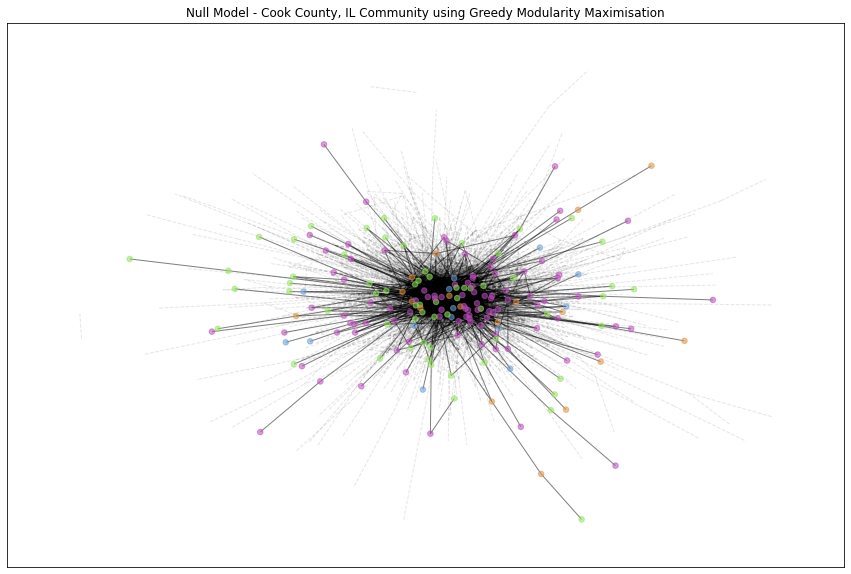

In [21]:
show_community(gmm_coms, 'Cook County, IL', 'gmm', 'Greedy Modularity Maximisation')

Community size: 165
Regions:
       Region  Counts
0    Midwest      75
1      South      65
2       West      16
3  Northeast       9


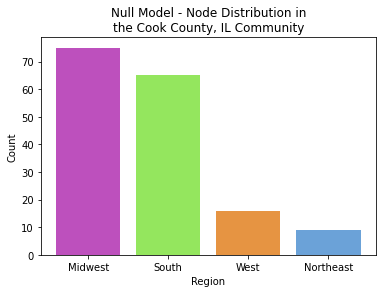

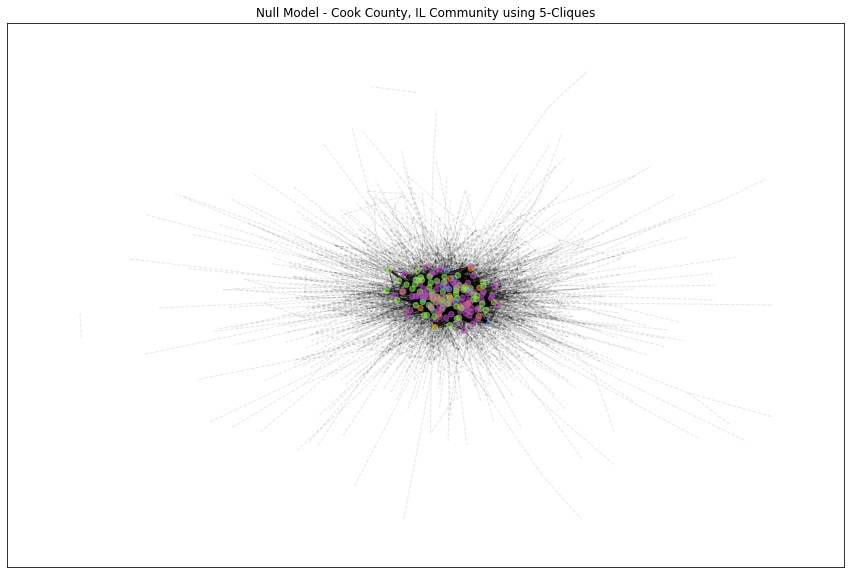

In [22]:
show_community(kc_coms, 'Cook County, IL', 'kclique', '5-Cliques')

In [23]:
# show_community(gmm_coms, 'Suffolk County, MA', 'gmm', 'Greedy Modularity Maximisation')

In [24]:
# show_community(kc_coms, 'Suffolk County, MA', 'kclique', '5-Cliques')

Community size: 199
Regions:
       Region  Counts
0      South      85
1    Midwest      81
2       West      19
3  Northeast      14


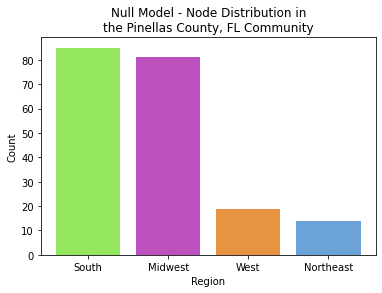

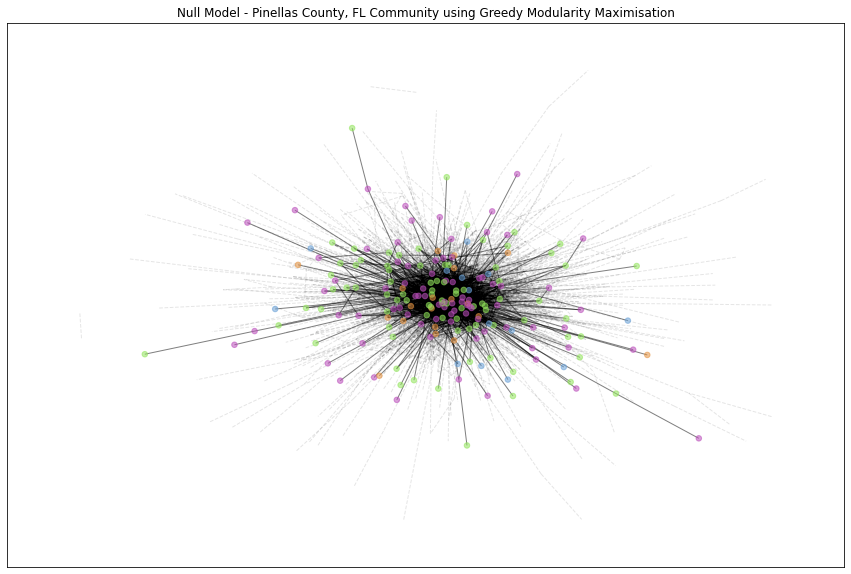

In [25]:
show_community(gmm_coms, 'Pinellas County, FL', 'gmm', 'Greedy Modularity Maximisation')

In [26]:
show_community(kc_coms, 'Pinellas County, FL', 'kclique', '5-Cliques')

No community found
